**Predicting Recidivism Using Random Forest Classifier [SMOTEENN]**

*The notebook uses random forest classifier to train and predict recidivism using data from the state of Iowa. The cleaned dataset consists of 21,611 rows and 17 columns. One of the columns, whether an individual returned to prison within 3 years of release, is used as the label [target feature]. Five of the attributes ['Recidivism Type','Days to Recidivism','New Conviction Offense Classification','New Conviction Offense Type','New Conviction Offense Sub Type'] represent information collected for recidivist prisoners and hence are not considered with the predictor features.* 

*The data shows 7,027 individuals returned to prison; therefore the positive to negative class ratio is ~1 : 2. Although not as extreme as in problems in areas such as fraud detection and infant mortality, there is imbalance in the data that requires balancing the data before applying machine learning algorithms. In this notebook,I use SMOTEENN from sklearn to oversample and clean the data.*

*SMOTE over-samples the minority class by generating new samples using interpolation. ENN cleans the oversampled data as SMOTE can generate noisy samples by interpolating marginal data points.* 

*Grid search is used to find optimum n_estimators and max_features.*

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

**Load cleaned data**

In [2]:
recidivism_data = pd.read_pickle('RecidivismData_forAnalysis')

**Look at the dimension of the dataset**

In [3]:
recidivism_data.shape

(21611, 17)

**Look at the list of the attributes**

In [4]:
list(recidivism_data.columns)

['Fiscal Year Released',
 'Recidivism Reporting Year',
 'Race - Ethnicity',
 'Sex',
 'Age At Release ',
 'Convicting Offense Classification',
 'Convicting Offense Type',
 'Convicting Offense Subtype',
 'Release Type',
 'Main Supervising District',
 'Recidivism - Return to Prison',
 'Recidivism Type',
 'Days to Recidivism',
 'New Conviction Offense Classification',
 'New Conviction Offense Type',
 'New Conviction Offense Sub Type',
 'Part of Target Population']

**Drop columns of information collected after recidivism**

Attributes, such as 'recidivism type', 'Days to Recidivism', and 'New Conviction Offense Classification', act as proxy to instance of recidivism. These attributes, are therefore excluded from further analysis.

In [5]:
recidivism_data.drop(['Recidivism Type','Days to Recidivism','New Conviction Offense Classification','New Conviction Offense Type','New Conviction Offense Sub Type'], axis = 1, inplace = True)

In [6]:
#remove any spaces around the attribute name
recidivism_data.rename(columns=lambda x: x.strip(),inplace = True)

In [7]:
#convert "Yes"/"No" to "1"/"0" for manipulation by LogisticRegression
recidivism_data = recidivism_data.replace({"Recidivism - Return to Prison":["Yes","No"]},{"Recidivism - Return to Prison":["1","0"]})

**Data Types**

In [8]:
categorical_attribute = ['Race - Ethnicity','Sex','Age At Release','Convicting Offense Classification',
                         'Convicting Offense Type','Convicting Offense Subtype','Release Type',
                         'Main Supervising District','Part of Target Population']

In [9]:
numerical_attribute = ['Fiscal Year Released','Recidivism Reporting Year']

In [10]:
binary_attribute = ['Recidivism - Return to Prison']

In [11]:
len(categorical_attribute), len(numerical_attribute), len(binary_attribute)

(9, 2, 1)

**Convert string type to int for numerical and binary attribute**

In [12]:
for i in numerical_attribute:
    recidivism_data['%s' % i] = recidivism_data['%s' % i].astype(int)

In [13]:
for i in binary_attribute:
    recidivism_data['%s' % i] = recidivism_data['%s' % i].astype(int)

**Encode categorical attributes**

In [14]:
df = pd.get_dummies(recidivism_data, prefix=categorical_attribute, columns=categorical_attribute)
df.shape

(21611, 91)

**Data Imbalance**

In [15]:
df['Recidivism - Return to Prison'].value_counts()

0    14584
1     7027
Name: Recidivism - Return to Prison, dtype: int64

In [16]:
df_features = list(df.columns)
df_features.remove('Recidivism - Return to Prison')
df_features.remove('Fiscal Year Released')
df_features.remove('Recidivism Reporting Year')

**Machine Learning**

In [17]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import classification_report
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

*The two main parameters that need adjustment when using Random Forest Classifier are the number of trees in the forest (n_estimators) and the size of the subset of features randomly selected at each split (max_features). Increasing the number of trees improves the model although the improvement becomes less significant beyond some critical number of trees. For classification problems, empirical studies show that the square root of the total number of features is the optimal number to of features to use at each split. I use OOB score to choose the best number of trees and subset of features [OOB score is a measure of accuracy of a model when it is fed samples not included when training the model].*

In [18]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

# Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

# Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(12,8))

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', markerfacecolor='none', ms=15, label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=24, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=18)
    ax.set_ylabel('CV Average Score', fontsize=18)
    ax.legend(loc="best", fontsize=15)
    ax.grid('off')
    plt.savefig('gridscores.eps',format = 'eps',dpi = 1300)

In [19]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    plot_grid_search(gs.cv_results_, param_grid['n_estimators'], param_grid['max_features'], 'N Estimators', 'Max Features')
    return best

In [20]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8, 
               test_size=0.2):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    X_resampled, y_resampled = SMOTEENN().fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, train_size=train_size)
    print(sorted(Counter(ytrain).items()))
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    oob_score = clf.oob_score_
    test_accuracy = clf.score(Xtest, ytest)
    print("OOB score of training data: {:0.2f}".format(oob_score))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest, X, y

[(0, 4784), (1, 8230)]
[(0, 3785), (1, 6626)]


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'max_features': 'log2', 'n_estimators': 77}
OOB score of training data: 0.96
Accuracy on test data:     0.96


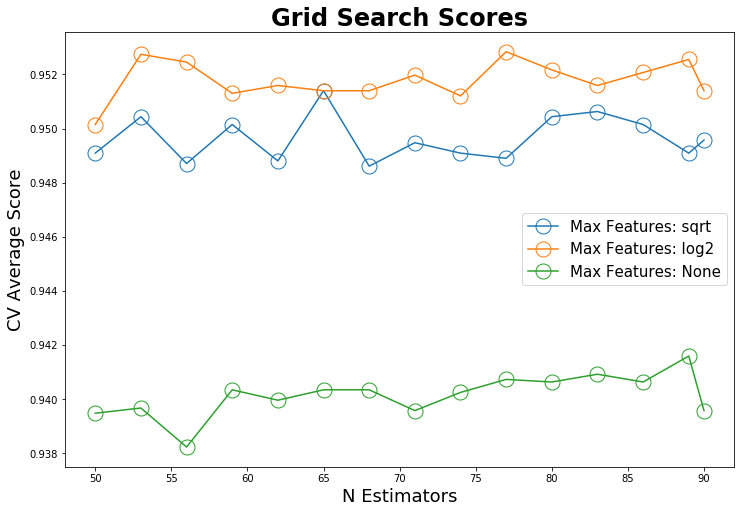

In [21]:
param_grid = {'n_estimators': [50,53,56,59,62,65,68,71,74,77,80,83,86,89,90],'max_features': ['sqrt','log2',None]}
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l, X, y  = do_classify(RandomForestClassifier(oob_score=True), param_grid,
                                                           df, df_features, 'Recidivism - Return to Prison',1)

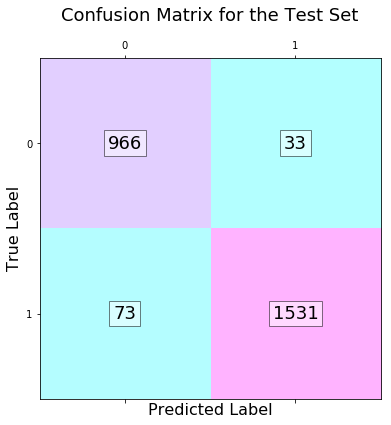

In [22]:
from matplotlib import rcParams
confmat_test = confusion_matrix(ytest_l, clf_l.predict(Xtest_l))
rcParams['axes.titlepad'] = 20 
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_test, cmap=plt.cm.cool, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center',fontsize=18,bbox=dict(facecolor='white', alpha=0.5))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Predicted Label',size=16)
plt.ylabel('True Label',size=16)
plt.title('Confusion Matrix for the Test Set',size=18)
plt.tight_layout()
plt.savefig('RF_SMOTE_ENN_Split_confusion_matrix_test.eps',format = 'eps',dpi = 1300)
plt.show()

In [23]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

In [24]:
TN_test, FP_test, FN_test, TP_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l)).ravel()

In [25]:
print(TN_test,TP_test,FP_test,FN_test)

966 1531 33 73


In [26]:
TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

In [27]:
print(classification_report(ytest_l, clf_l.predict(Xtest_l)))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       999
          1       0.98      0.95      0.97      1604

avg / total       0.96      0.96      0.96      2603



In [28]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cmt_test = pd.DataFrame(cm_test)

[[ 966   33]
 [  73 1531]]


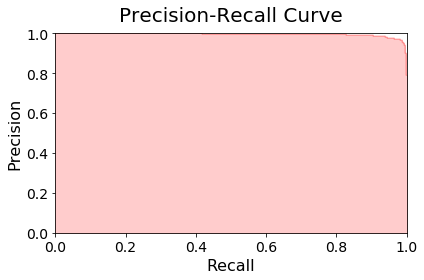

In [29]:
from sklearn.metrics import precision_recall_curve
precision_test, recall_test, _ = precision_recall_curve(ytest_l, clf_l.predict_proba(Xtest_l)[:,1])
rcParams['axes.titlepad'] = 12 
plt.step(recall_test, precision_test, color='r', alpha=0.2,where='post')
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2,color='r')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Recall',size=16)
plt.ylabel('Precision',size=16)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve',size=20)
plt.tight_layout()
plt.savefig('RF_SMOTE_ENN_Split_precision_recall_test.png',format = 'png')

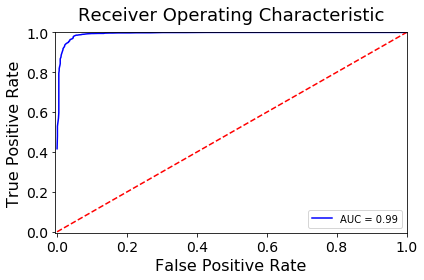

In [30]:
from sklearn.metrics import roc_curve, auc
fpr1_test, tpr1_test, _ = roc_curve(ytest_l, clf_l.predict_proba(Xtest_l)[:,1])
roc_auc_test = auc(fpr1_test, tpr1_test)
plt.title('Receiver Operating Characteristic',size=18)
plt.plot(fpr1_test, tpr1_test, 'b',label='AUC = %0.2f'% roc_auc_test)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
rcParams['axes.titlepad'] = 20 
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.005,1.0])
plt.ylim([-0.005,1.0])
plt.ylabel('True Positive Rate',size=16)
plt.xlabel('False Positive Rate',size=16)
plt.tight_layout()
plt.savefig('RF_SMOTE_ENN_Split_ROC_test.eps',format = 'eps',dpi = 1300)
plt.show()

### Confusion matrix for training data

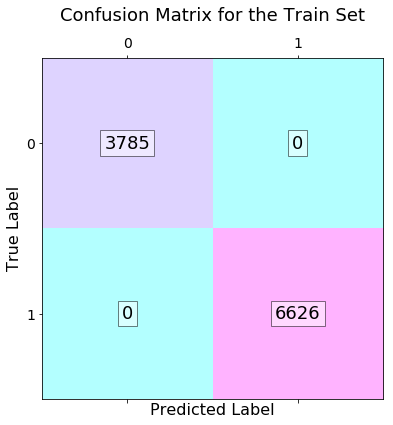

In [31]:
confmat_train = confusion_matrix(ytrain_l, clf_l.predict(Xtrain_l))
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_train, cmap=plt.cm.cool, alpha=0.3)
for i in range(confmat_train.shape[0]):
    for j in range(confmat_train.shape[1]):
        ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center',fontsize=18,bbox=dict(facecolor='white', alpha=0.5))
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.xlabel('Predicted Label',size=16)
plt.ylabel('True Label',size=16)
plt.title('Confusion Matrix for the Train Set',size=18)
plt.tight_layout()
plt.savefig('RF_SMOTE_ENN_Split_Confusion_matrix_train.eps',format = 'eps',dpi = 1300)
plt.show()

In [32]:
TN_train,FP_train,FN_train,TP_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l)).ravel()

In [33]:
print(TN_train,TP_train,FP_train,FN_train)

3785 6626 0 0


In [34]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

In [35]:
print(classification_report(ytrain_l, clf_l.predict(Xtrain_l)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3785
          1       1.00      1.00      1.00      6626

avg / total       1.00      1.00      1.00     10411



In [36]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [37]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [38]:

performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.636,0.364,10411,1.0,1.0,1.0,1.0
Test Set,0.616,0.384,2603,0.959,0.979,0.954,0.967


In [39]:
coefficients = pd.concat([pd.DataFrame(df_features),pd.DataFrame(np.transpose(clf_l.feature_importances_))], axis = 1)

In [40]:
#list(zip(pd.DataFrame(Xtrain_l,columns=df_features), clf_l.feature_importances_))

In [41]:
coefficients.columns = ['attributes','coefficient']
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()

In [42]:
coefficients.sort_values(by='abs_coefficient', ascending=False).head(20)

,attributes,coefficient,abs_coefficient
9,Race - Ethnicity_White - Non-Hispanic,0.044657,0.044657
12,Age At Release_25-34,0.041731,0.041731
85,Main Supervising District_Unknown,0.037300,0.037300
21,Convicting Offense Classification_D Felony,0.035931,0.035931
79,Main Supervising District_5JD,0.034582,0.034582
15,Age At Release_55 and Older,0.034334,0.034334
74,Release Type_Unknown,0.033631,0.033631
13,Age At Release_35-44,0.033232,0.033232
14,Age At Release_45-54,0.031613,0.031613
6,Race - Ethnicity_Black - Non-Hispanic,0.031532,0.031532


Feature ranking:
1. feature Race - Ethnicity_White - Non-Hispanic (0.044657)
2. feature Age At Release_25-34 (0.041731)
3. feature Main Supervising District_Unknown (0.037300)
4. feature Convicting Offense Classification_D Felony (0.035931)
5. feature Main Supervising District_5JD (0.034582)
6. feature Age At Release_55 and Older (0.034334)
7. feature Release Type_Unknown (0.033631)
8. feature Age At Release_35-44 (0.033232)
9. feature Age At Release_45-54 (0.031613)
10. feature Race - Ethnicity_Black - Non-Hispanic (0.031532)
11. feature Part of Target Population_No (0.029439)
12. feature Convicting Offense Classification_Aggravated Misdemeanor (0.028228)
13. feature Convicting Offense Classification_C Felony (0.026939)
14. feature Age At Release_Under 25 (0.026280)
15. feature Sex_F (0.025993)
16. feature Race - Ethnicity_White - Hispanic (0.025405)
17. feature Part of Target Population_Yes (0.024514)
18. feature Main Supervising District_1JD (0.021980)
19. feature Release Type_Disch

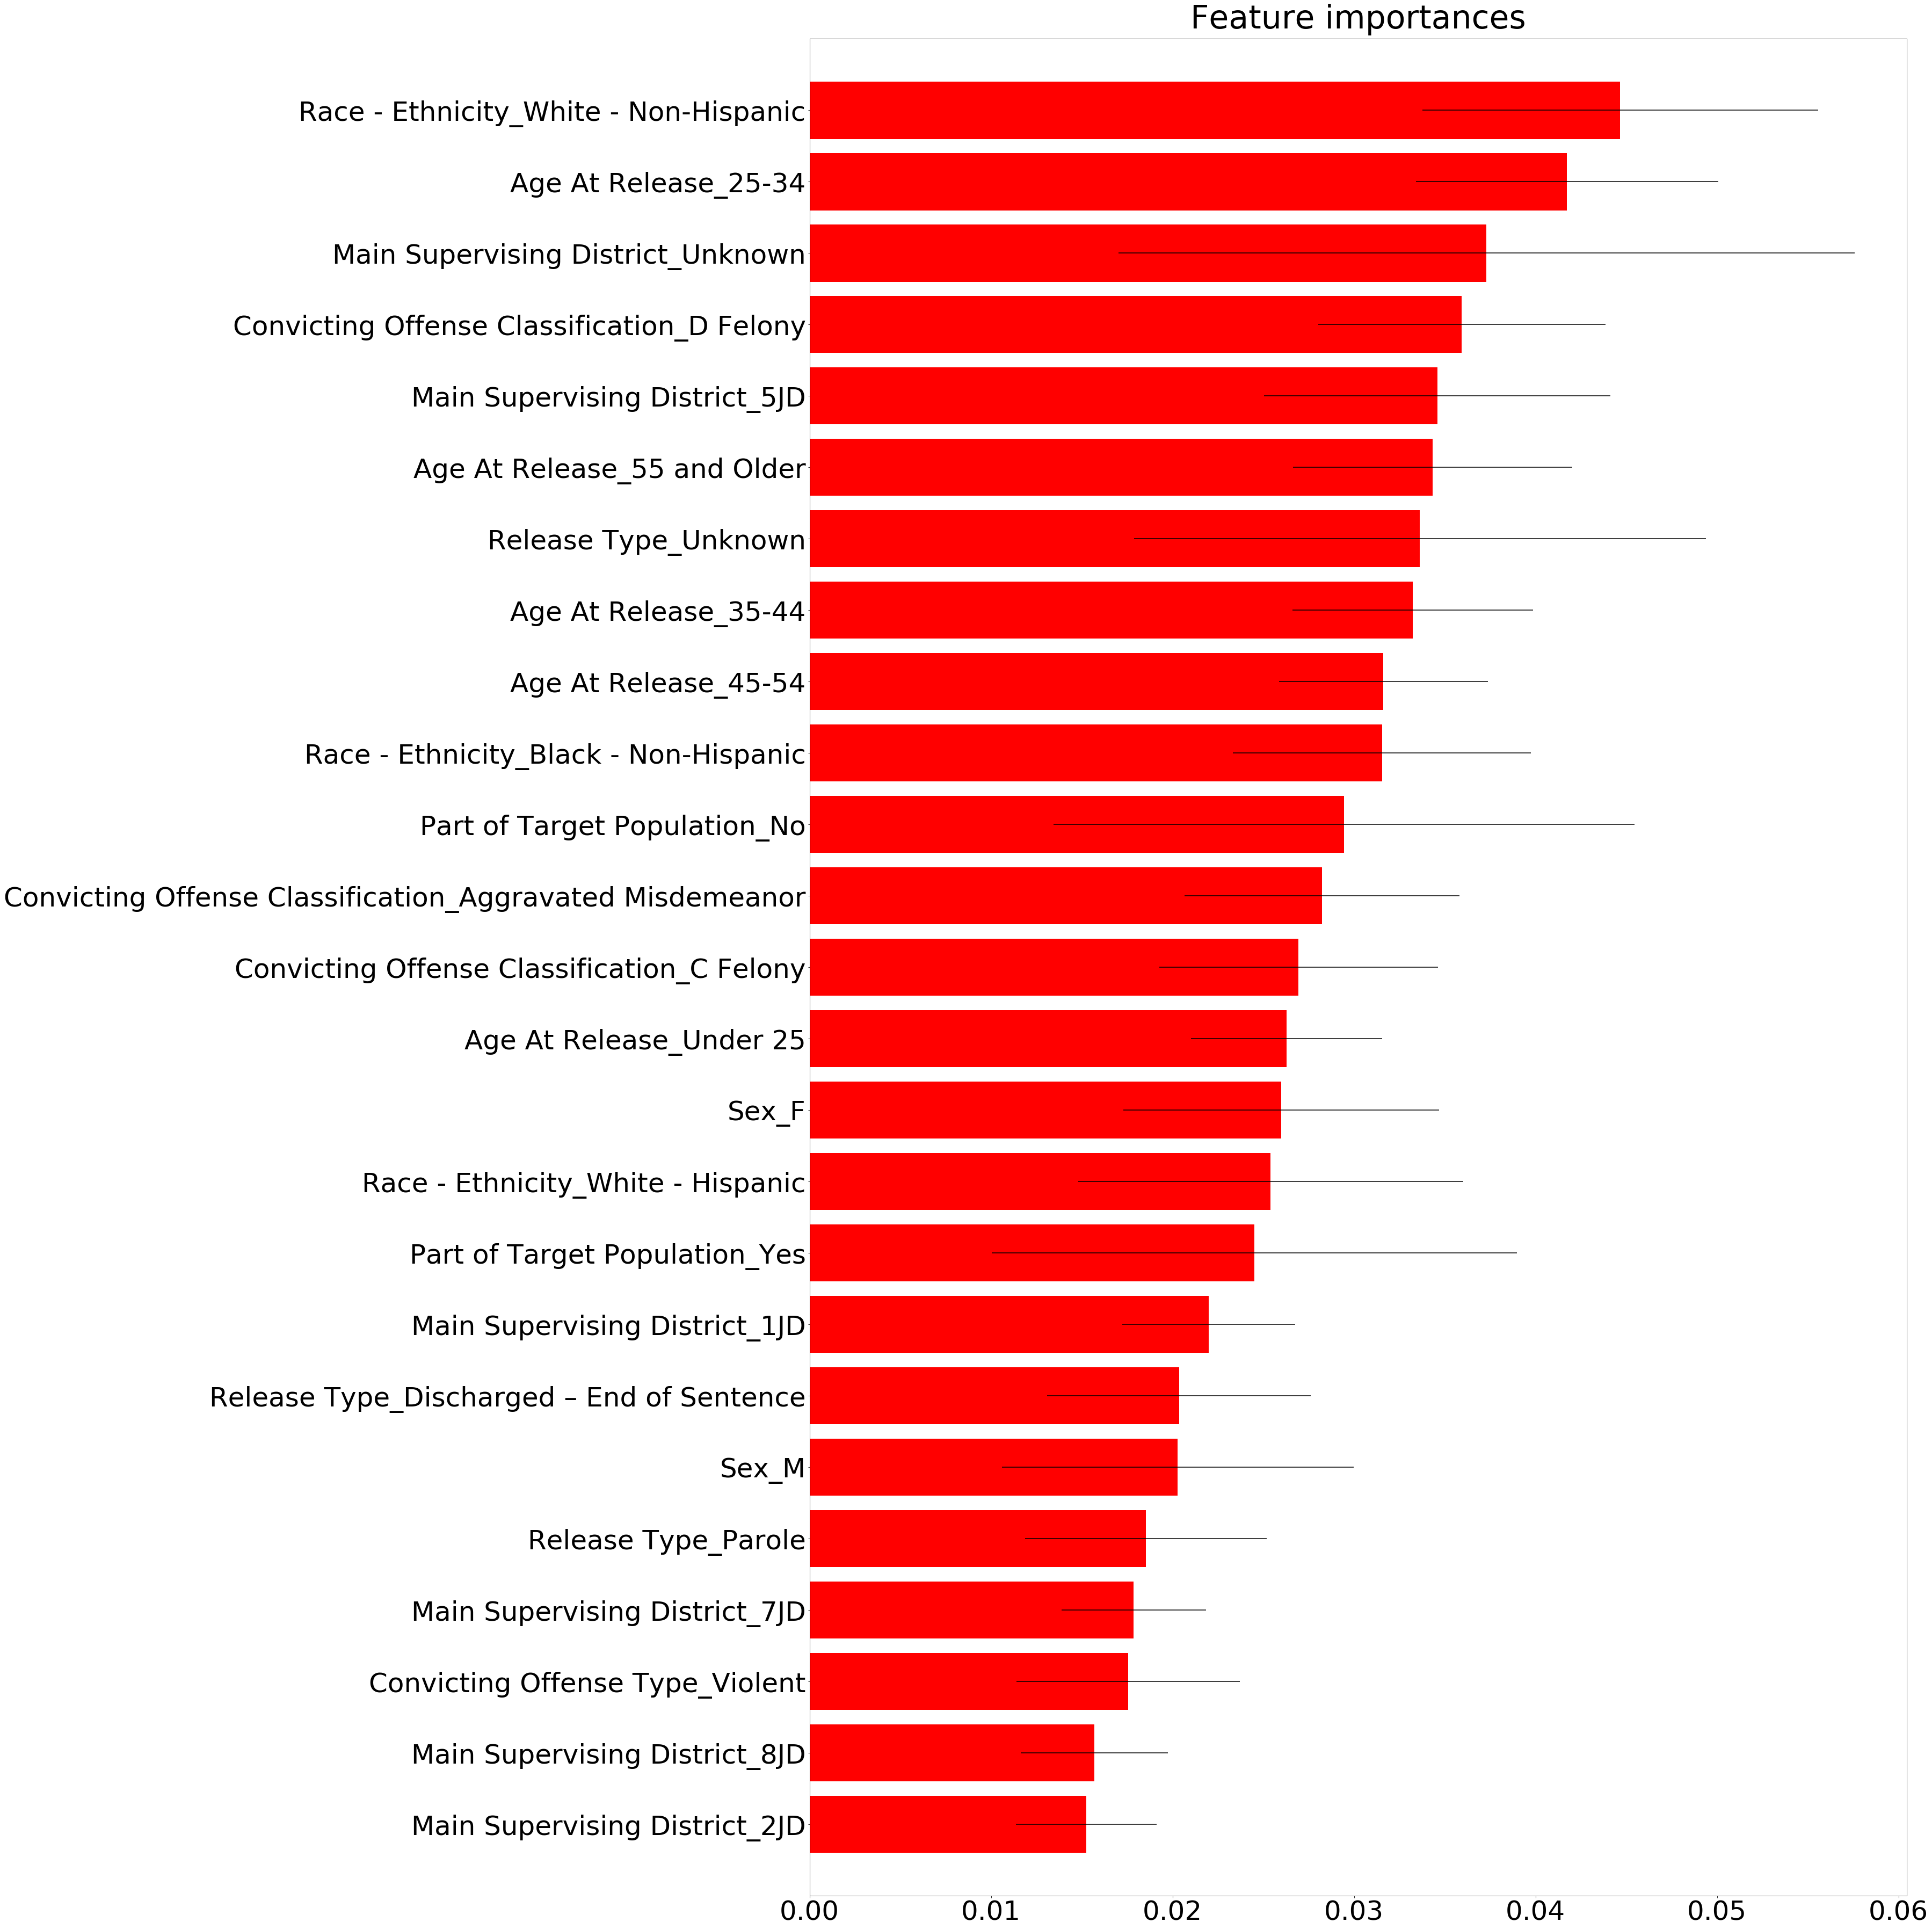

In [73]:
importances = clf_l.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_l.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices = indices[0:25]

# Print the feature ranking
print("Feature ranking:")

for f in range(25):
    print("%d. feature %s (%f)" % (f + 1, coefficients.attributes[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(50,50))
plt.title("Feature importances",fontsize=60)
plt.barh(range(25), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(25), coefficients.attributes[indices], fontsize=50)
plt.xticks(fontsize=50)
plt.ylim([25, -1])
plt.tight_layout()
plt.savefig('RF_SMOTE_ENN_Split_feature_importance.eps',format = 'eps',dpi = 2300)

plt.show()

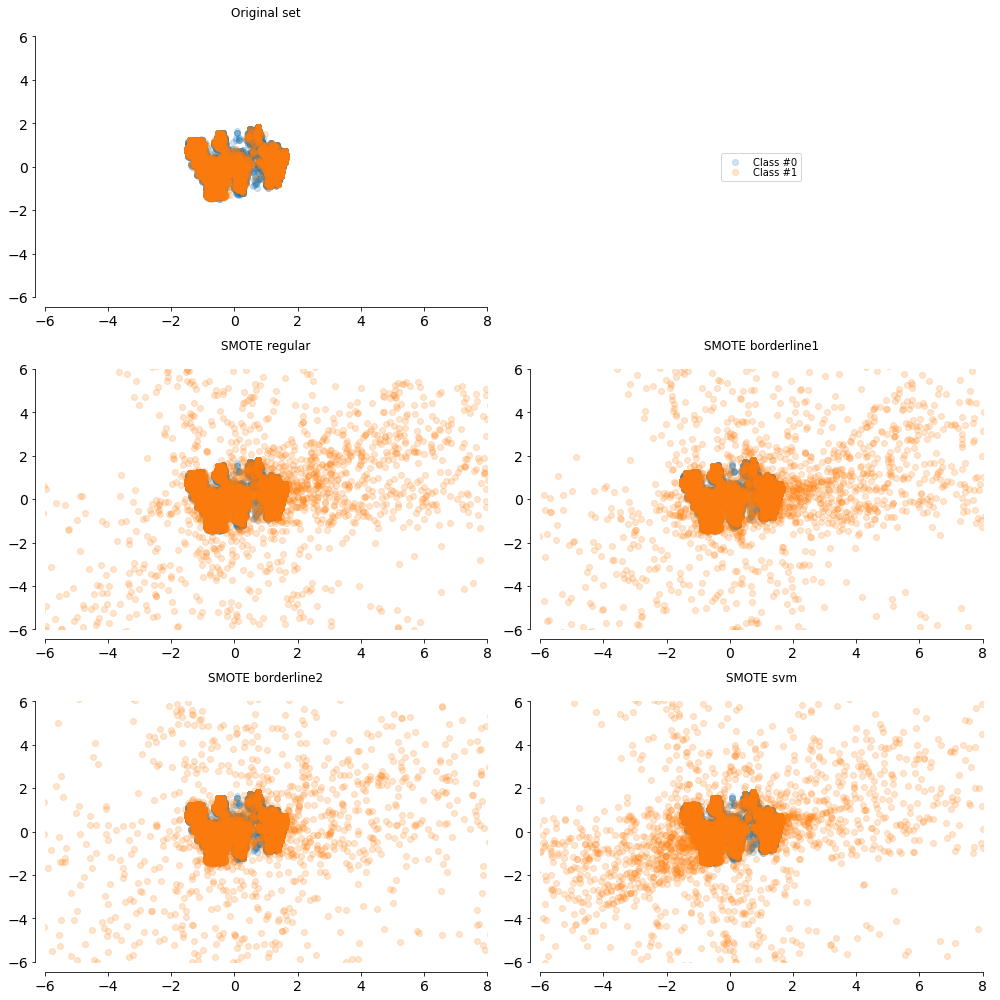

In [44]:

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

def plot_resampling(ax, X, y, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.2)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.2)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

    return c0, c1
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply regular SMOTE
kind = ['regular', 'borderline1', 'borderline2', 'svm']
sm = [SMOTE(kind=k) for k in kind]
X_resampled = []
y_resampled = []
X_res_vis = []
for method in sm:
    X_res, y_res = method.fit_sample(X, y)
    X_resampled.append(X_res)
    y_resampled.append(y_res)
    X_res_vis.append(pca.transform(X_res))

# Two subplots, unpack the axes array immediately
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14))
# Remove axis for second plot
ax2.axis('off')
ax_res = [ax3, ax4, ax5, ax6]

c0, c1 = plot_resampling(ax1, X_vis, y, 'Original set')
for i in range(len(kind)):
    plot_resampling(ax_res[i], X_res_vis[i], y_resampled[i],
                    'SMOTE {}'.format(kind[i]))

ax2.legend((c0, c1), ('Class #0', 'Class #1'), loc='center',
           ncol=1, labelspacing=0.)
plt.tight_layout()
plt.show()